In [1]:
!pip install -q -U transformers sentence_transformers faiss-gpu peft trl accelerate wandb bitsandbytes

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.


In [2]:
!pip install datasets

In [3]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset , DatasetDict

In [4]:
dataset = load_dataset("b-mc2/sql-create-context", split="train")

# Calculate the indices for the last 8000 samples
last_2k_start = len(dataset) - 2000

# Select the desired samples for the training set
train_dataset = dataset.select(list(range(0, 1000)) + list(range(35000, 36000)) + list(range(last_2k_start, len(dataset))))

# Create an eval set with remaining samples
eval_dataset = dataset.select(list(range(3000, 5000)))

# Create a DatasetDict with the split datasets
dataset = DatasetDict({
    'train': train_dataset,
    'eval': eval_dataset
})


Generating train split:   0%|          | 0/78577 [00:00<?, ? examples/s]

In [5]:
df = dataset['train'].to_pandas()

In [6]:
df.shape

(4000, 3)

In [7]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
base_model = "/kaggle/input/gemma-2/transformers/gemma-2-2b-it/1"

In [9]:
tokenizer = AutoTokenizer.from_pretrained(base_model)

In [10]:
context_counts = [len(tokenizer.tokenize(text['context'])) for text in dataset['train']]

In [11]:
instruction_counts = [len(tokenizer.tokenize(text['question'])) for text in dataset['train']]

In [12]:
output_counts = [len(tokenizer.tokenize(text['answer'])) for text in dataset['train']]

In [13]:
total_counts = [instruction + output + context for instruction , output, context in zip(instruction_counts , output_counts, context_counts)]

In [14]:
def plot_distribution(counts:str, title:str):
  sns.set_style('whitegrid')
  plt.hist(counts , bins = 50)
  plt.xlabel('Tokens')
  plt.ylabel('Frequency')
  plt.title(title)
  plt.xticks(fontsize = 12)
  plt.yticks(fontsize = 12)
  plt.tight_layout()
  plt.show()


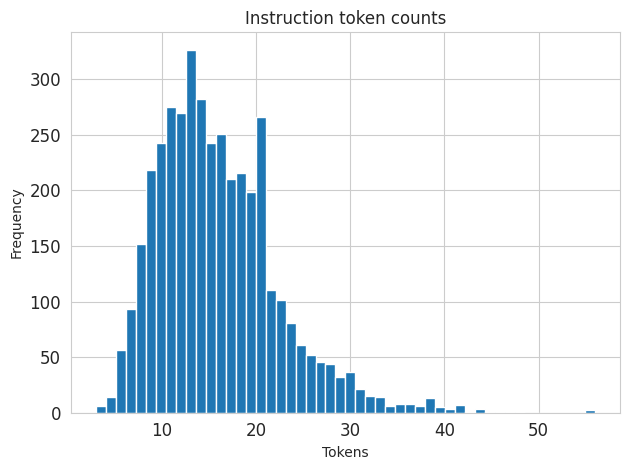

In [15]:
plot_distribution(instruction_counts, "Instruction token counts")

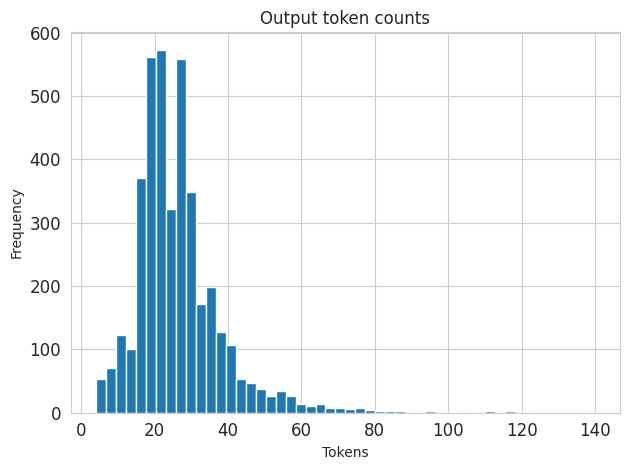

In [16]:
plot_distribution(output_counts, "Output token counts")

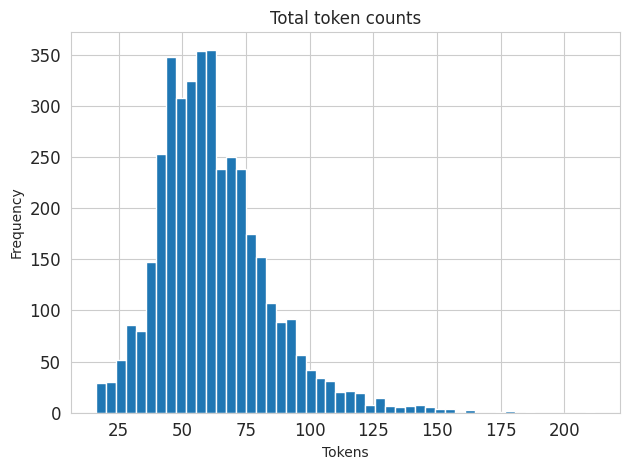

In [17]:
plot_distribution(total_counts, "Total token counts")

In [18]:
indices_to_keep = [i for i , count in enumerate(total_counts) if count<=2048]

In [19]:
len(indices_to_keep)

4000

In [20]:
len(dataset['train']) - len(indices_to_keep)

0

In [21]:
dataset['train'] = dataset['train'].select(indices_to_keep)

In [22]:
def chat_template(example):
    example['question'] = f"### CONTEXT:\n{example['context']}\n\n### QUESTION:{example['question']}\n\n### [RESPONSE]:\n{example['answer']}"
    return example

dataset = dataset.map(chat_template)


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [23]:
print(dataset['train'].to_pandas()['question'].iloc[0])

### CONTEXT:
CREATE TABLE head (age INTEGER)

### QUESTION:How many heads of the departments are older than 56 ?

### [RESPONSE]:
SELECT COUNT(*) FROM head WHERE age > 56


In [24]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import (
    LoraConfig,
    PeftModel,
    prepare_model_for_kbit_training,
    get_peft_model,
)
import os, torch, wandb
from datasets import load_dataset
from trl import SFTTrainer

2024-08-21 11:36:42.003089: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 11:36:42.003248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 11:36:42.134612: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [25]:
tokenizer = AutoTokenizer.from_pretrained(base_model , use_fast = True)
tokenizer.pad_token = tokenizer.eos_token 
tokenizer.padding_side = "right"
tokenizer.add_eos_token = True
tokenizer.add_bos_token, tokenizer.add_eos_token

(True, True)

In [26]:
dataset

DatasetDict({
    train: Dataset({
        features: ['answer', 'question', 'context'],
        num_rows: 4000
    })
    eval: Dataset({
        features: ['answer', 'question', 'context'],
        num_rows: 2000
    })
})

In [27]:
bnbConfig = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
        base_model,
        quantization_config=bnbConfig,
        device_map="auto"
)

model.config.use_cache = False # silence the warnings. Please re-enable for inference!
model.config.pretraining_tp = 1
model.gradient_checkpointing_enable()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [28]:
model = prepare_model_for_kbit_training(model)
peft_config = LoraConfig(
    lora_alpha=32,
    lora_dropout=0.1,
    r=32,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['o_proj', 'q_proj', 'up_proj', 'v_proj', 'k_proj', 'down_proj', 'gate_proj']
)
model = get_peft_model(model, peft_config)

In [29]:
training_arguments = TrainingArguments(
    output_dir="./kaggle/working/gemma-7b-v1-sqlgpt",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    optim="paged_adamw_8bit",
    save_strategy="epoch",
    logging_steps=100,
    logging_strategy="steps",
    learning_rate=2e-4,
    fp16=False,
    bf16=False,
    group_by_length=True,
    report_to="wandb"
)

In [30]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset['train'],
    eval_dataset = dataset['eval'],
    peft_config=peft_config,
    max_seq_length= 512,
    dataset_text_field="question",
    tokenizer=tokenizer,
    args=training_arguments,
    packing= False,
)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length, dataset_text_field. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [31]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

In [32]:
secret_wandb = user_secrets.get_secret("wandb")

# Monitoring the LLM
wandb.login(key = secret_wandb)
run = wandb.init(
    project='Fine tuning Gemma 2B', 
    job_type="training", 
    anonymous="allow"
)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: awaistahseen009. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.17.7
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240821_113732-3zy00e02
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run crimson-dew-4
wandb: ⭐️ View project at https://wandb.ai/awaistahseen009/Fine%20tuning%20Gemma%202B
wandb: 🚀 View run at https://wandb.ai/awaistahseen009/Fine%20tuning%20Gemma%202B/runs/3zy00e02


In [33]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
It is strongly recommended to train Gemma2 models with the `eager` attention implementation instead of `sdpa`. Use `eager` with `AutoModelForCausalLM.from_pretrained('<path-to-checkpoint>', attn_implementation='eager')`.
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
100,1.019700
200,0.879900
300,0.840500
400,0.796000
500,0.755100
600,0.745000
700,0.751000
800,0.718700
900,0.712000
1000,0.695400


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=3000, training_loss=0.5523716824849446, metrics={'train_runtime': 3583.8356, 'train_samples_per_second': 3.348, 'train_steps_per_second': 0.837, 'total_flos': 1.1812293107011584e+16, 'train_loss': 0.5523716824849446, 'epoch': 3.0})

In [34]:
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:         train/epoch ▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
wandb:   train/global_step ▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
wandb:     train/grad_norm █▄▄▅▅▆▇▅▆▅▅█▄▄█▃▇▆▅▄▂▁▄▃▄▄▅▅▃▄
wandb: train/learning_rate ███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
wandb:          train/loss █▇▆▆▅▅▅▅▅▅▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:               total_flos 1.1812293107011584e+16
wandb:              train/epoch 3.0
wandb:        train/global_step 3000
wandb:          train/grad_norm 1.0308
wandb:      train/learning_rate 0.0
wandb:               train/loss 0.3356
wandb:               train_loss 0.55237
wandb:            train_runtime 3583.8356
wandb: train_samples_per_second 3.348
wandb:   train_steps_per_second 0.837
wandb: 
wandb: 🚀 View run crimson-dew-4 at: https://wandb.ai/awaistahseen009/Fine%20tuning%20Gemma%202B/runs/3zy00e02
wandb: ⭐️ View project at: https://wandb.ai/awa

In [35]:
new_model = "sql_gpt_latest"

In [36]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("huggingface")

In [37]:
!huggingface-cli login --token $secret_value_0

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [38]:
trainer.model.save_pretrained(new_model)

In [39]:
trainer.model.push_to_hub(new_model, use_temp_dir=False)

adapter_model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/awais009/sql_gpt_latest/commit/c23696d2610def2969eece99787e0f7c85e4af2d', commit_message='Upload model', commit_description='', oid='c23696d2610def2969eece99787e0f7c85e4af2d', pr_url=None, pr_revision=None, pr_num=None)

In [40]:
model.config.use_cache = True

In [41]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from peft import PeftModel
import torch



base_model_reload = AutoModelForCausalLM.from_pretrained(
        base_model,
        return_dict=True,
        low_cpu_mem_usage=True,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [42]:
trained_model = PeftModel.from_pretrained(base_model_reload, new_model)

In [43]:
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [44]:
prompt = '''
### CONTEXT:\nCREATE TABLE trip (start_station_id VARCHAR, duration VARCHAR); CREATE TABLE station (lat VARCHAR, long VARCHAR, city VARCHAR, id VARCHAR)\n\n### QUESTION:What is the latitude, longitude, city of the station from which the shortest trip started?\n\n### [RESPONSE]:\n
'''
    
inputs = tokenizer(prompt, return_tensors='pt', padding=False, truncation=True).to("cuda")

outputs = trained_model.generate(**inputs, max_length=500, num_return_sequences=1)

text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(text[len(prompt):].split("###")[0])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


SELECT T1.lat, T1.long, T1.city FROM station AS T1 JOIN trip AS T2 ON T1.id = T2.start_station_id ORDER BY T2.duration LIMIT 1


